In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

from ocr import catalog
from ocr.config import OCRConfig

warnings.filterwarnings('ignore')

In [2]:
config = OCRConfig(storage_root='/tmp/era5-vs-conus404')
config

OCRConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', vector=VectorConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='intermediate/fire-risk/vector/qa', output_prefix='output/fire-risk/vector/qa', debug=False), icechunk=IcechunkConfig(environment=<Environment.QA: 'qa'>, version=None, storage_root='/tmp/era5-vs-conus404', prefix='output/fire-risk/tensor/qa/ocr.icechunk', debug=False), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=False, spot_policy='spot_with_fallback', region='us-west-2', ntasks=1, vm_type='m8g.2xlarge', scheduler_vm_type='m8g.2xlarge'), debug=False)

In [3]:
def apply_kendall_tau(x, y):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant='b')
    return pd.Series({'tau': tau, 'p_value': p_value})

In [4]:
def apply_bias(x, y):
    bias = np.mean(x - y)
    return pd.Series({'bias': bias})

In [5]:
def apply_median(x, label):
    median = np.median(x)
    return pd.Series({f'median_{label}': median})

In [6]:
def apply_mean(x, label):
    mean = np.mean(x)
    return pd.Series({f'mean_{label}': mean})

In [7]:
def fraction_zeros(x, y):
    x_fract_zero = (x == 0).sum() / len(x)
    y_fract_zero = (y == 0).sum() / len(y)
    return pd.Series({'x_fract_zero': x_fract_zero, 'y_fract_zero': y_fract_zero})

In [8]:
def apply_corr(x, y):
    corr = np.corrcoef(x, y)
    return pd.Series({'corr': corr[0, 1]})

In [9]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [10]:
census_tracts = gpd.read_parquet(
    's3://carbonplan-ocr/input/fire-risk/vector/aggregated_regions/tracts/tracts.parquet'
)

In [11]:
census_tracts = census_tracts.rename({'GEOID': 'GEOID_right'}, axis=1)

In [12]:
# NOTE: if either of these are True you need to be on a machine with ~200GB memory
remake_building_tract_file = False
remake_tract_stats_file = False
version = '0.7.0'
if remake_building_tract_file:
    # NOTE: anything reading this file requires being on a machine with ~200GB memory
    building_file = gpd.read_parquet(
        f's3://carbonplan-ocr/output/fire-risk/vector/production/v{version}/geoparquet/consolidated-buildings.parquet'
    )
    building_file = building_file.drop(['bbox'], axis=1)
    # intersects will duplicate buildings that straddle multiple census tracts. we could clean this up
    # later by de-duplicating buildings
    buildings_in_census_tracts = gpd.sjoin(building_file, census_tracts[['GEOID', 'geometry']])
    buildings_in_census_tracts.to_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_tracts_{version}_geo.parquet'
    )
if remake_tract_stats_file:
    # NOTE: anything reading this file requires being on a machine with ~200GB memory
    if remake_building_tract_file:
        buildings_in_census_tracts = gpd.read_parquet(
            f's3://carbonplan-risks/shapefiles/buildings_tracts_{version}_geo.parquet'
        )

    df_buildings_in_census_tracts = buildings_in_census_tracts[
        ['USFS_RPS', 'wind_risk_2011', 'wind_risk_2047', 'GEOID_right']
    ]
    tract_tau = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: apply_kendall_tau(g['wind_risk_2011'], g['USFS_RPS'])
    )
    tract_performance_stats = census_tracts[['GEOID_right', 'geometry']].merge(
        tract_tau, on='GEOID_right'
    )
    # add what fraction of the buildings have zero risk because those tracts should be removed since tau is NaN
    new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: fraction_zeros(g['wind_risk_2011'], g['USFS_RPS'])
    )
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add correlation calculation
    new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: apply_corr(g['wind_risk_2011'], g['USFS_RPS'])
    )
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add bias calculation
    new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: apply_bias(g['wind_risk_2011'], g['USFS_RPS'])
    )
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add mean calculation for both x and y
    for setup in ['wind_risk_2011', 'USFS_RPS']:
        new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
            lambda g: apply_mean(g[setup], setup)
        )
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add median calculation for both x and y
    for setup in ['wind_risk_2011', 'USFS_RPS']:
        new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
            lambda g: apply_median(g[setup], setup)
        )
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    tract_performance_stats['normalized_bias'] = (
        tract_performance_stats['bias'] / tract_performance_stats['mean_USFS_RPS']
    )
    # filter out any places that are all zeros in either CP or USFS because they'll either make for NaN kendall tau or infinity in bias
    tract_performance_stats = tract_performance_stats[
        ~(tract_performance_stats['x_fract_zero'] == 1)
    ]
    tract_performance_stats = tract_performance_stats[
        ~(tract_performance_stats['y_fract_zero'] == 1)
    ]
    tract_performance_stats = tract_performance_stats.rename({'GEOID_right': 'GEOID'}, axis=1)
    tract_performance_stats.to_parquet(
        f's3://carbonplan-risks/shapefiles/tracts_stats_geo_{version}.parquet'
    )
else:
    tract_performance_stats = gpd.read_parquet(
        f's3://carbonplan-risks/shapefiles/tracts_stats_geo_{version}.parquet'
    )

In [13]:
def find_hotspots(quantile, tract_df, direction):
    hot_spot_thresholds = tract_df[['bias', 'normalized_bias']].quantile(quantile, axis=0)
    if direction == 'high':
        bias_filter = tract_df['bias'] > hot_spot_thresholds['bias']
        normalized_bias_filter = (
            tract_df['normalized_bias'] > hot_spot_thresholds['normalized_bias']
        )
    elif direction == 'low':
        bias_filter = tract_df['bias'] < hot_spot_thresholds['bias']
        normalized_bias_filter = (
            tract_df['normalized_bias'] < hot_spot_thresholds['normalized_bias']
        )
    return tract_df[bias_filter & normalized_bias_filter]

## Top 3 hot spot tracts where we overpredict w.r.t. WRC are all around LA

In [52]:
high_bias_hotspots = find_hotspots(0.99, tract_performance_stats, 'high')

In [53]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
high_bias_hotspots.centroid.plot(ax=axarr)

<Axes: >

In [54]:
high_bias_hotspots.bounds

minx       miny        maxx       maxy
4440  -118.294696  34.248018 -118.285924  34.255904
5086  -118.299451  34.252299 -118.287333  34.255978
5961  -118.315747  34.258690 -118.297917  34.266971
7756  -117.592980  33.630502 -117.577540  33.648800
9453  -118.248753  34.213031 -118.230759  34.229566
9916  -118.266269  34.163072 -118.255153  34.169615
11005 -118.556773  34.032636 -118.529261  34.049890
11049 -118.537667  34.024999 -118.517867  34.049743
11057 -118.456710  34.307587 -118.439908  34.321786
11398 -117.670412  34.134514 -117.651299  34.150601
72499  -98.528214  33.973867  -98.518581  33.979962

In [55]:
high_bias_hotspots.to_file(f'high_bias_tracts_{version}.shp')

## Now look at low hotspots - places where we're saying low risk compared to WRC

In [56]:
low_bias_hotspots = find_hotspots(0.005, tract_performance_stats, 'low')
len(low_bias_hotspots)

12

In [57]:
low_bias_hotspots.to_file(f'low_bias_tracts_{version}.shp')

<Axes: >

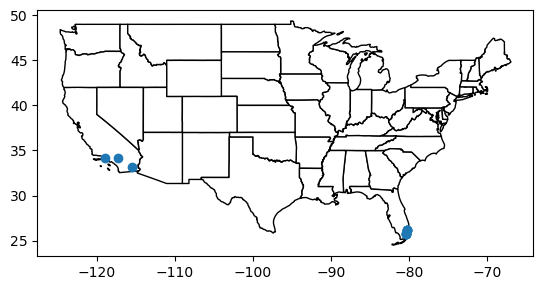

In [58]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
low_bias_hotspots.centroid.plot(ax=axarr)

# Hotspots of low correlation

<Axes: >

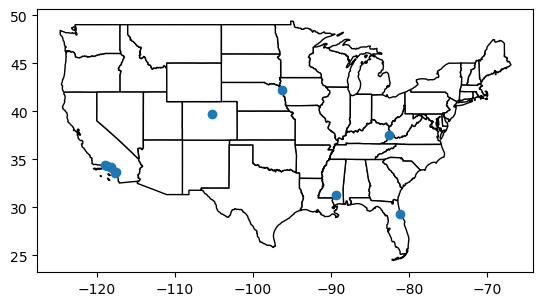

In [22]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
tract_performance_stats.sort_values('corr').head(10).centroid.plot(ax=axarr)

In [51]:
tract_performance_stats.sort_values('corr').head(10).to_file(
    f'corr_low_tracts_{version}.shp'
)  # (f'corr_low_tracts_{version}.shp')

In [10]:
variable_name_dict = {
    'tau': "Kendall's Tau of RPS",
    'bias': 'RPS bias (CP - Scott)',
    'corr': 'Correlation (CP vs. Scott)',
    'median_wind_risk_2011': 'CP median RPS',
    'median_USFS_RPS': 'Scott median RPS',
    'mean_wind_risk_2011': 'CP mean RPS',
    'mean_USFS_RPS': 'Scott mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - Scott)/Scott)',
}
var_lims = {'tau': [-1, 1], 'bias': [-0.1, 0.1], 'normalized_bias': [-1, 1], 'corr': [-1, 1]}

cmaps = {'tau': 'PRGn', 'bias': 'RdBu_r', 'normalized_bias': 'RdBu_r', 'corr': 'PRGn'}

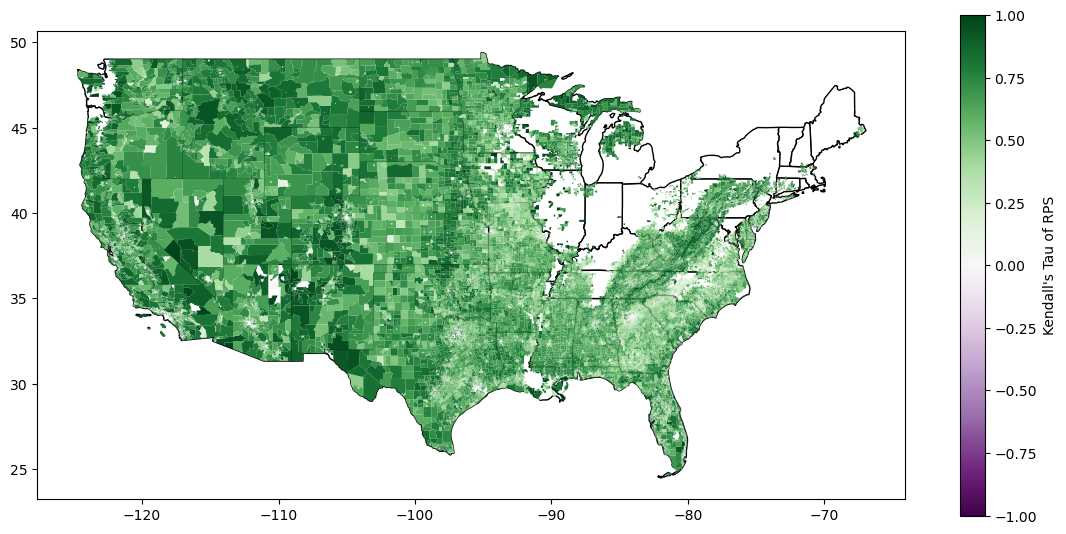

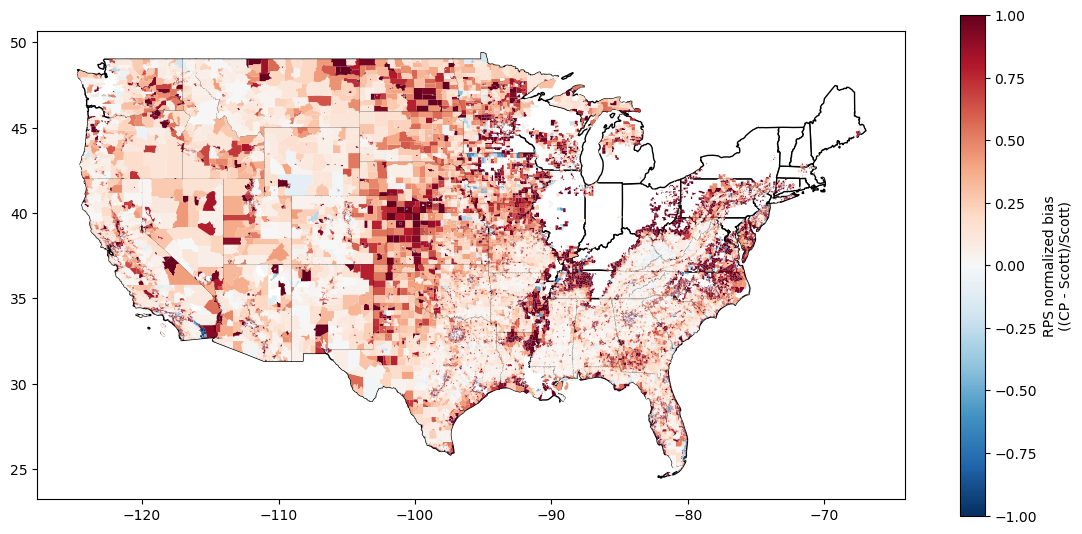

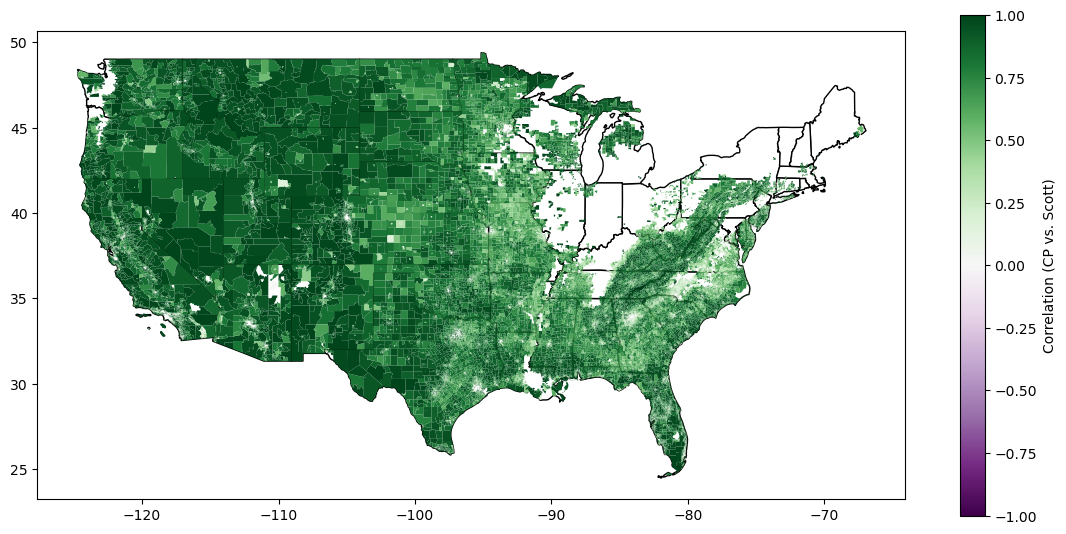

In [11]:
for variable in ['tau', 'bias', 'normalized_bias', 'corr']:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

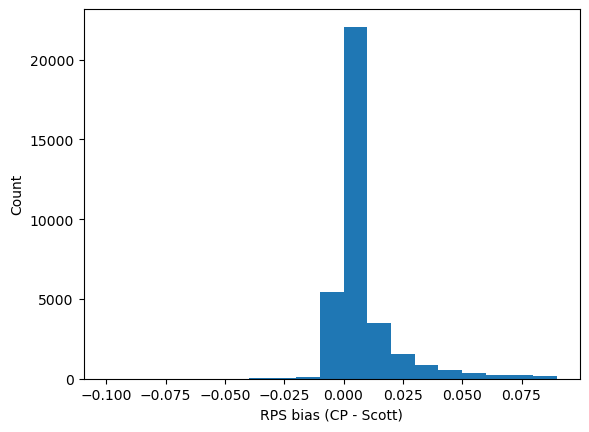

In [15]:
for statistic in ['corr', 'bias', 'normalized_bias']:
    plt.figure()
    plt.hist(
        tract_performance_stats[statistic].values,
        bins=np.arange(var_lims[statistic][0], var_lims[statistic][1], var_lims[statistic][1] / 10),
    )
    # plt.legend()
    plt.xlabel(variable_name_dict[statistic])
    plt.ylabel('Count')
    plt.title('CONUS-wide census-tract level comparison with Scott (2024)=')

In [ ]:
plt.hist(tract_performance_stats['normalized_bias'].values, bins=np.arange(-1, 1, 0.1))
# plt.hist(tract_performance_stats['CarbonPlan tau_c'].values, bins=np.arange(-1, 1, 0.1), label='CarbonPlan', alpha=0.5)
plt.legend()
plt.xlabel('Normalized bias')
plt.ylabel('Count')
plt.title('Correlation of CarbonPlan with Scott')

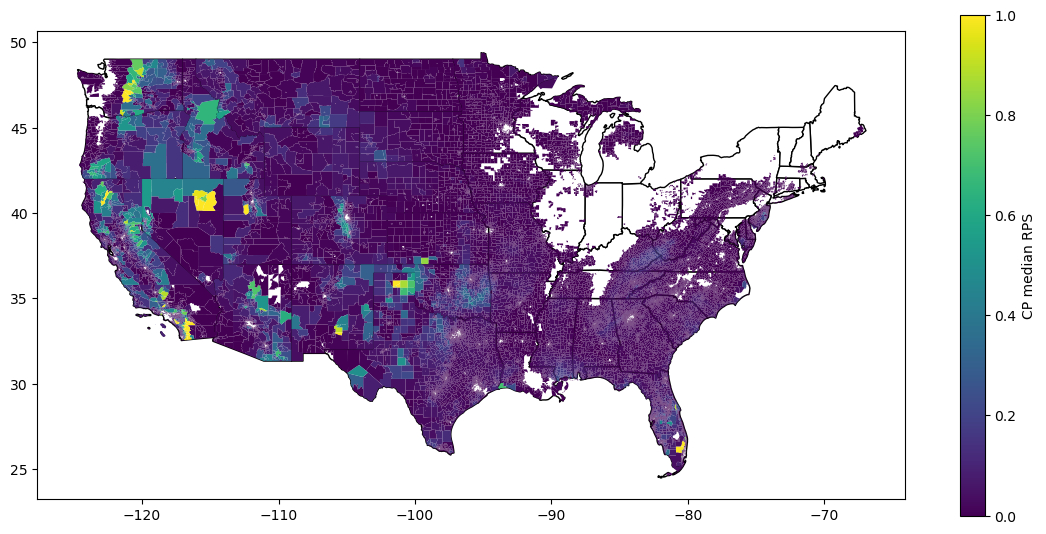

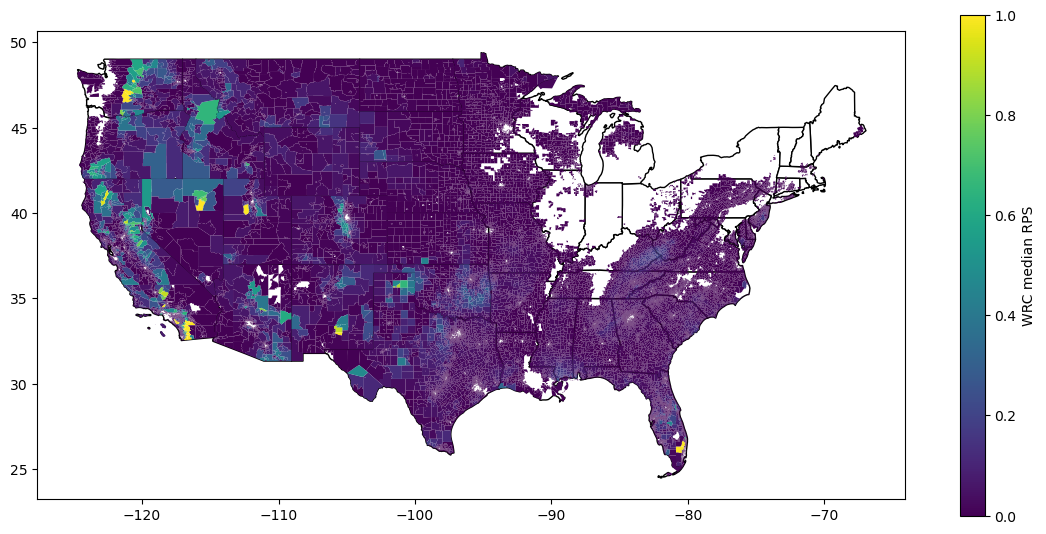

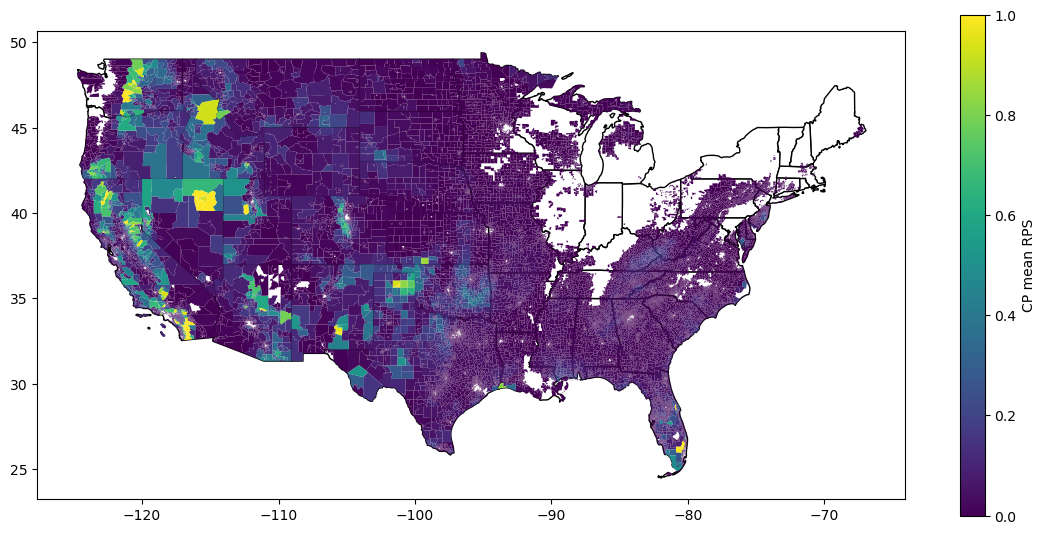

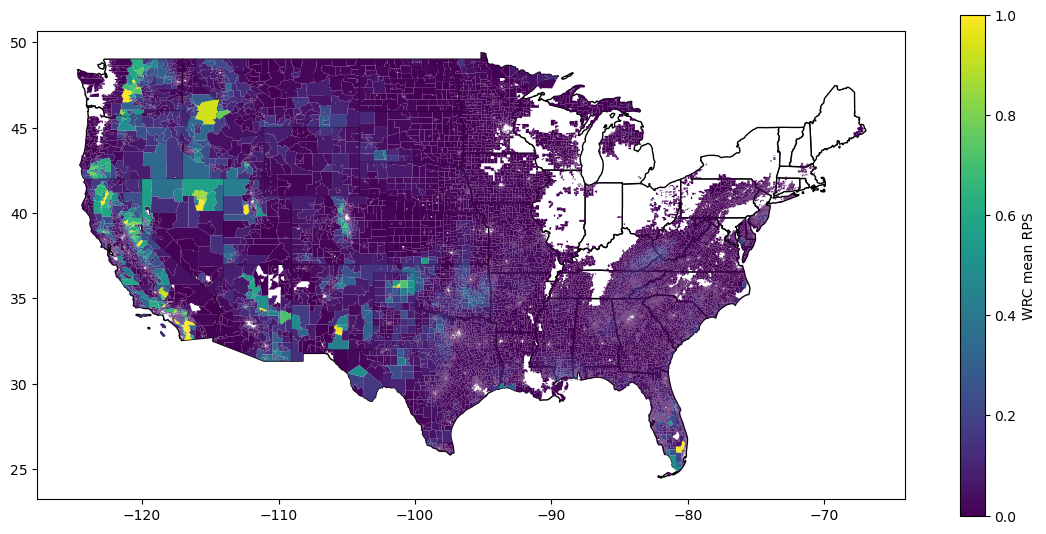

In [55]:
for variable in [
    'median_wind_risk_2011',
    'median_USFS_RPS',
    'mean_wind_risk_2011',
    'mean_USFS_RPS',
]:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=0,
        vmax=1,
        legend=True,
        cmap='viridis',
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

# Finding hotspots of bias

In [15]:
hotspots = find_hotspots(0.98, tract_performance_stats, 'high')

In [16]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
hotspots.centroid.plot(ax=axarr)

<Axes: >

In [18]:
wind_ds = catalog.get_dataset(
    'conus404-ffwi-p99-wind-direction-distribution-reprojected'
).to_xarray()

In [19]:
buildings_in_census_tracts = gpd.read_parquet(
    's3://carbonplan-risks/shapefiles/buildings_tracts_0.4.0_geo.parquet'
)

In [94]:
projected_cts = census_tracts.to_crs('epsg:5070')

## Scatter plots of buildings in census tracts of high bias

In [129]:
def scatter_plot_buildings_hotspot_tracts(
    hotspot_geoids, buildings_in_census_tracts, census_tracts, wind_ds, states
):
    fig, axarr = plt.subplots(nrows=8, ncols=5, figsize=(15, 25))
    for i, geoid in enumerate(hotspot_geoids):
        buildings = buildings_in_census_tracts[buildings_in_census_tracts['GEOID'] == geoid]
        tract_lat = census_tracts[census_tracts['GEOID'] == geoid].geometry.centroid.y.values[0]
        tract_lon = census_tracts[census_tracts['GEOID'] == geoid].geometry.centroid.x.values[0]
        distrib = [
            np.round(num, decimals=1)
            for num in np.sort(
                wind_ds.sel(
                    latitude=tract_lat, longitude=tract_lon, method='nearest'
                ).wind_direction_distribution.values
            )
        ]
        axarr.flatten()[i].scatter(
            buildings['USFS_RPS'].values, buildings['wind_risk_2011'].values, alpha=0.1
        )
        axarr.flatten()[i].text(
            0.2, 0.8, f'n={len(buildings)}', transform=axarr.flatten()[i].transAxes
        )
        axarr.flatten()[i].text(
            0.2,
            0.7,
            states[states['STATEFP'] == geoid[0:2]]['NAME'].values[0],
            transform=axarr.flatten()[i].transAxes,
        )
        axarr.flatten()[i].text(
            0.2,
            0.6,
            '{:.1f} km2'.format(
                (
                    census_tracts[census_tracts['GEOID'] == geoid].to_crs('EPSG:5070').area / (1e6)
                ).values[0]
            ),
            transform=axarr.flatten()[i].transAxes,
        )
        axarr.flatten()[i].text(
            0.2,
            0.5,
            f'{sum(distrib[-3:]) * 100:.0f}% in top two wind dirs',
            transform=axarr.flatten()[i].transAxes,
        )
        axarr.flatten()[i].set_xlabel('RPS WRC')
        axarr.flatten()[i].set_ylabel('RPS CP')
        xlims = axarr.flatten()[i].get_xlim()
        ylims = axarr.flatten()[i].get_ylim()
        max_value = max(xlims[1], ylims[1])
        min_value = min(xlims[0], ylims[0])
        axarr.flatten()[i].set_xlim(min_value, max_value)
        axarr.flatten()[i].set_ylim(min_value, max_value)
    plt.tight_layout()

In [137]:
hotspots = find_hotspots(0.98, tract_performance_stats, 'high')
hotspot_geoids = hotspots['GEOID'].values

CPU times: user 3min 6s, sys: 8.52 s, total: 3min 14s
Wall time: 3min 16s


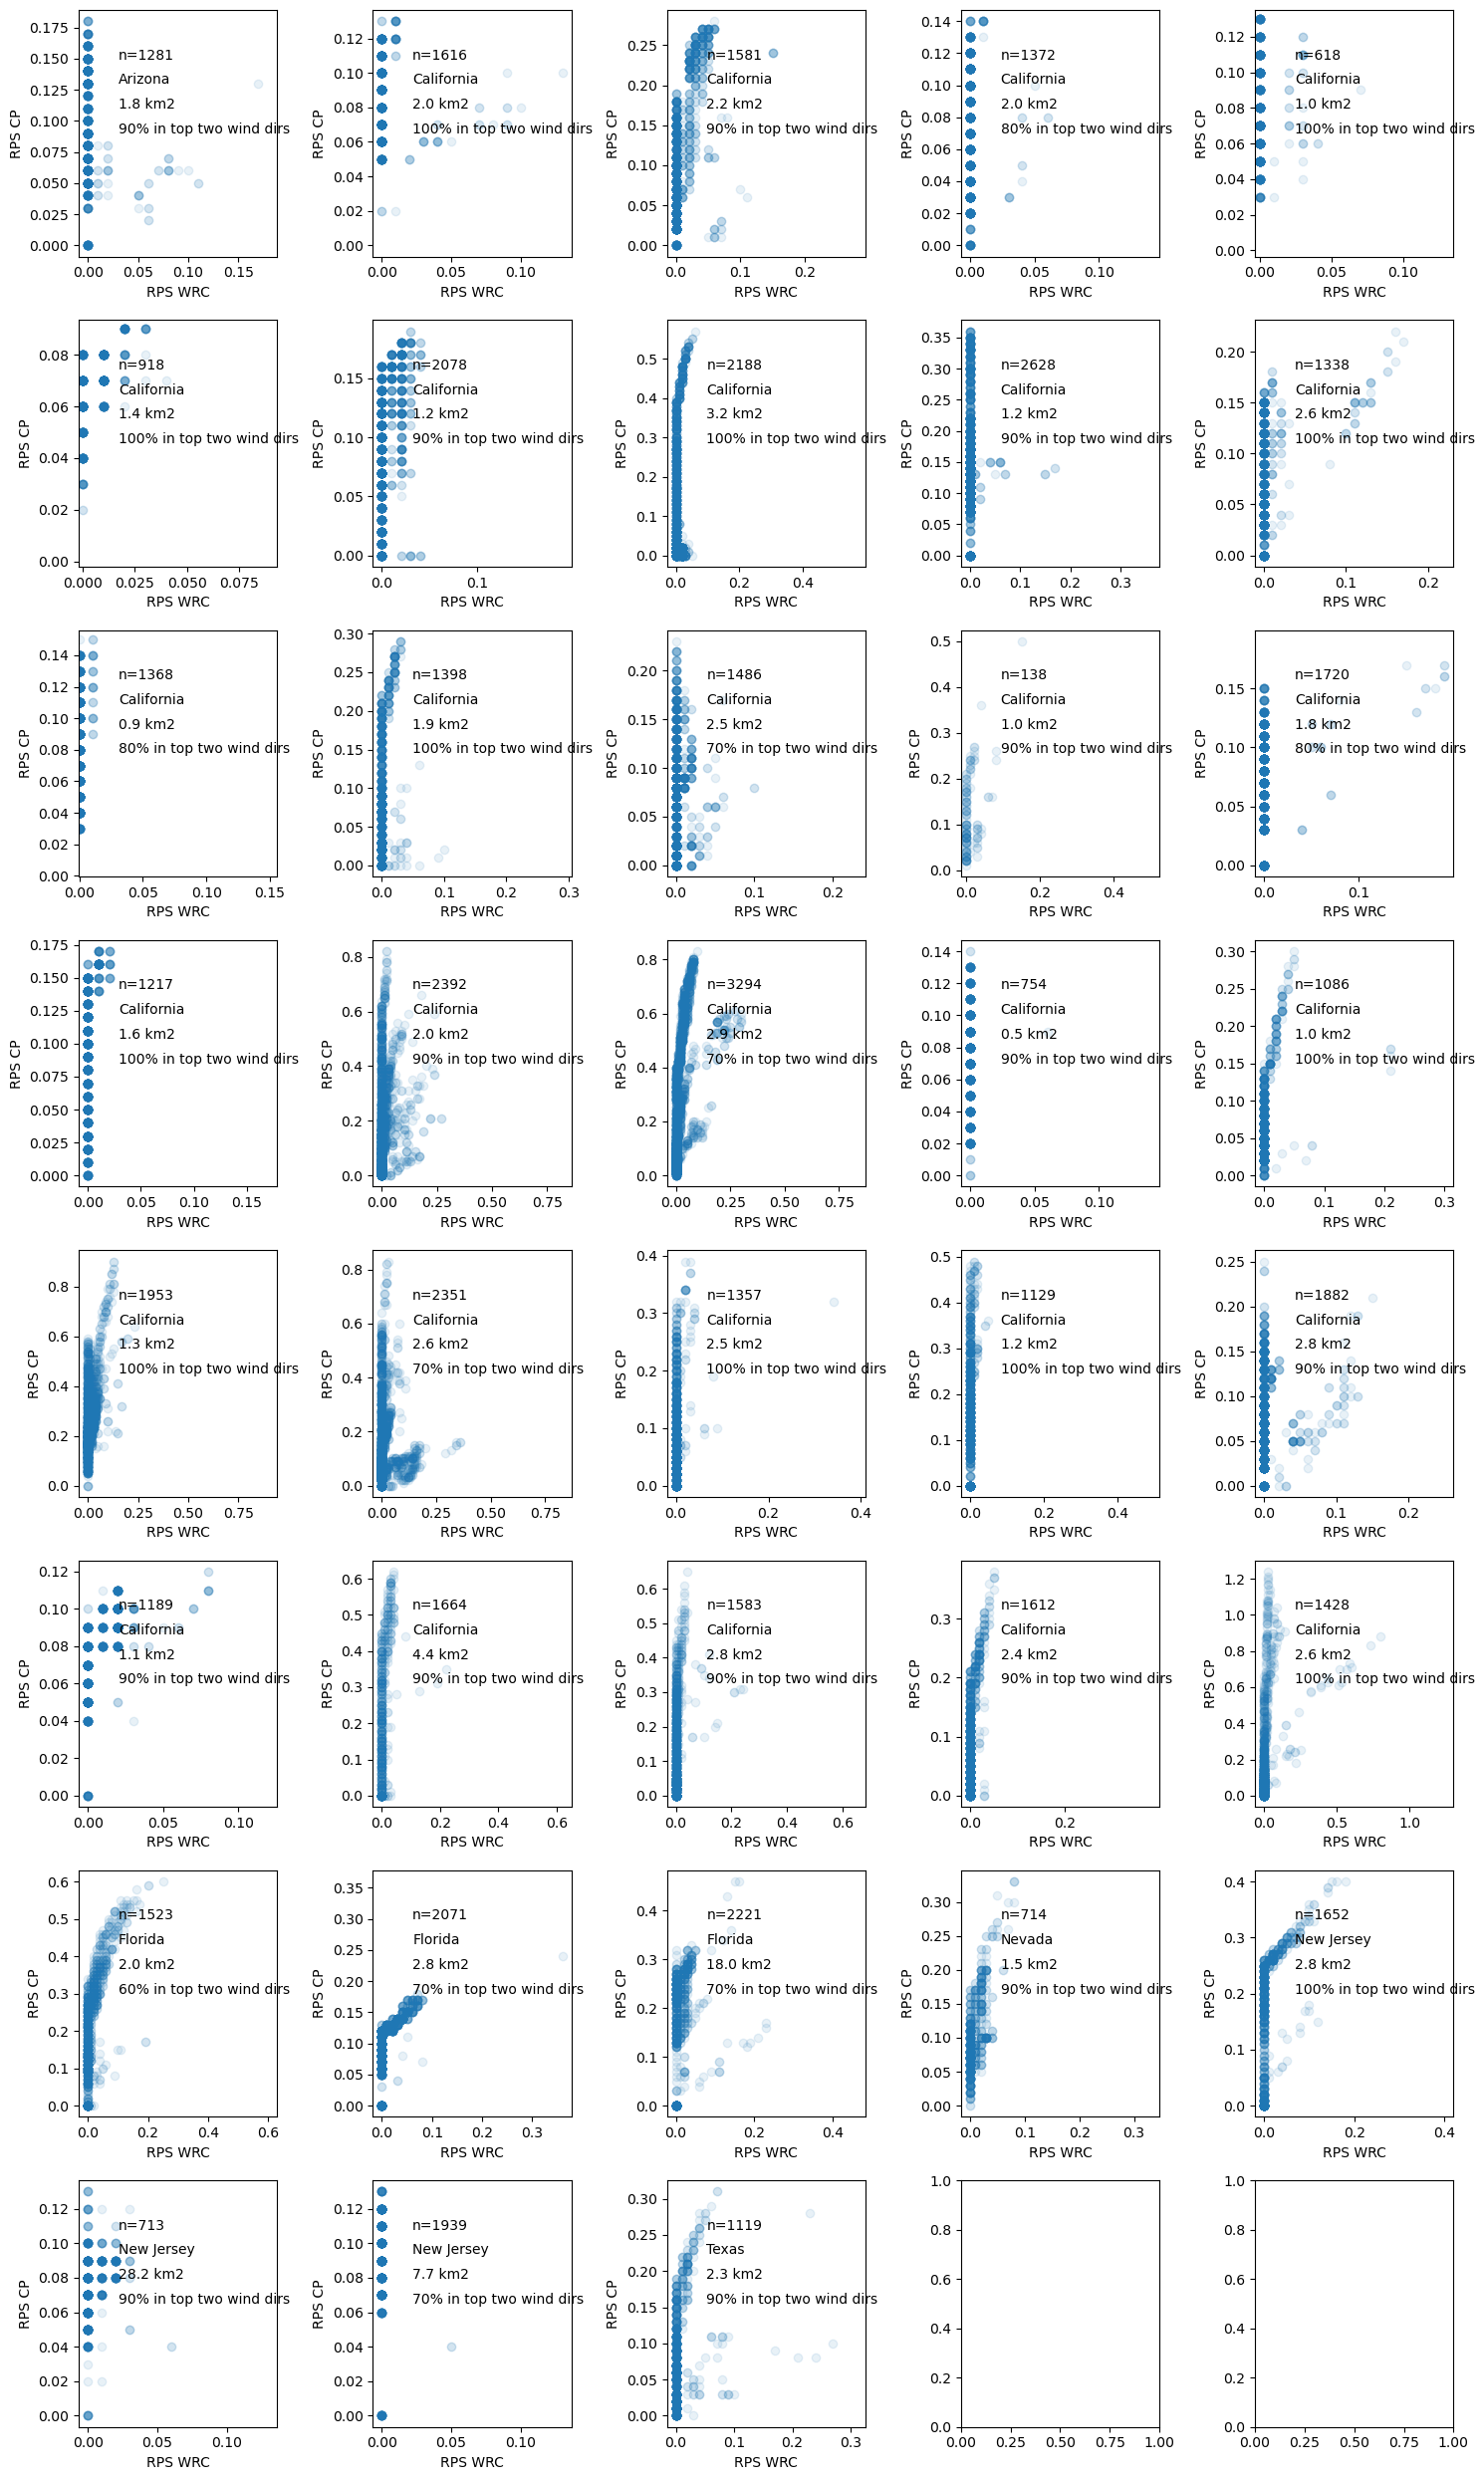

In [139]:
%%time
scatter_plot_buildings_hotspot_tracts(
    hotspot_geoids, buildings_in_census_tracts, census_tracts, wind_ds, states
)

## Scatter plots of buildings in census tracts of low bias - plot the same number of tracts for consistency

In [132]:
hotspots = find_hotspots(0.049, tract_performance_stats, 'low')

In [133]:
hotspot_geoids = hotspots['GEOID'].values

CPU times: user 3min 10s, sys: 8.85 s, total: 3min 18s
Wall time: 3min 20s


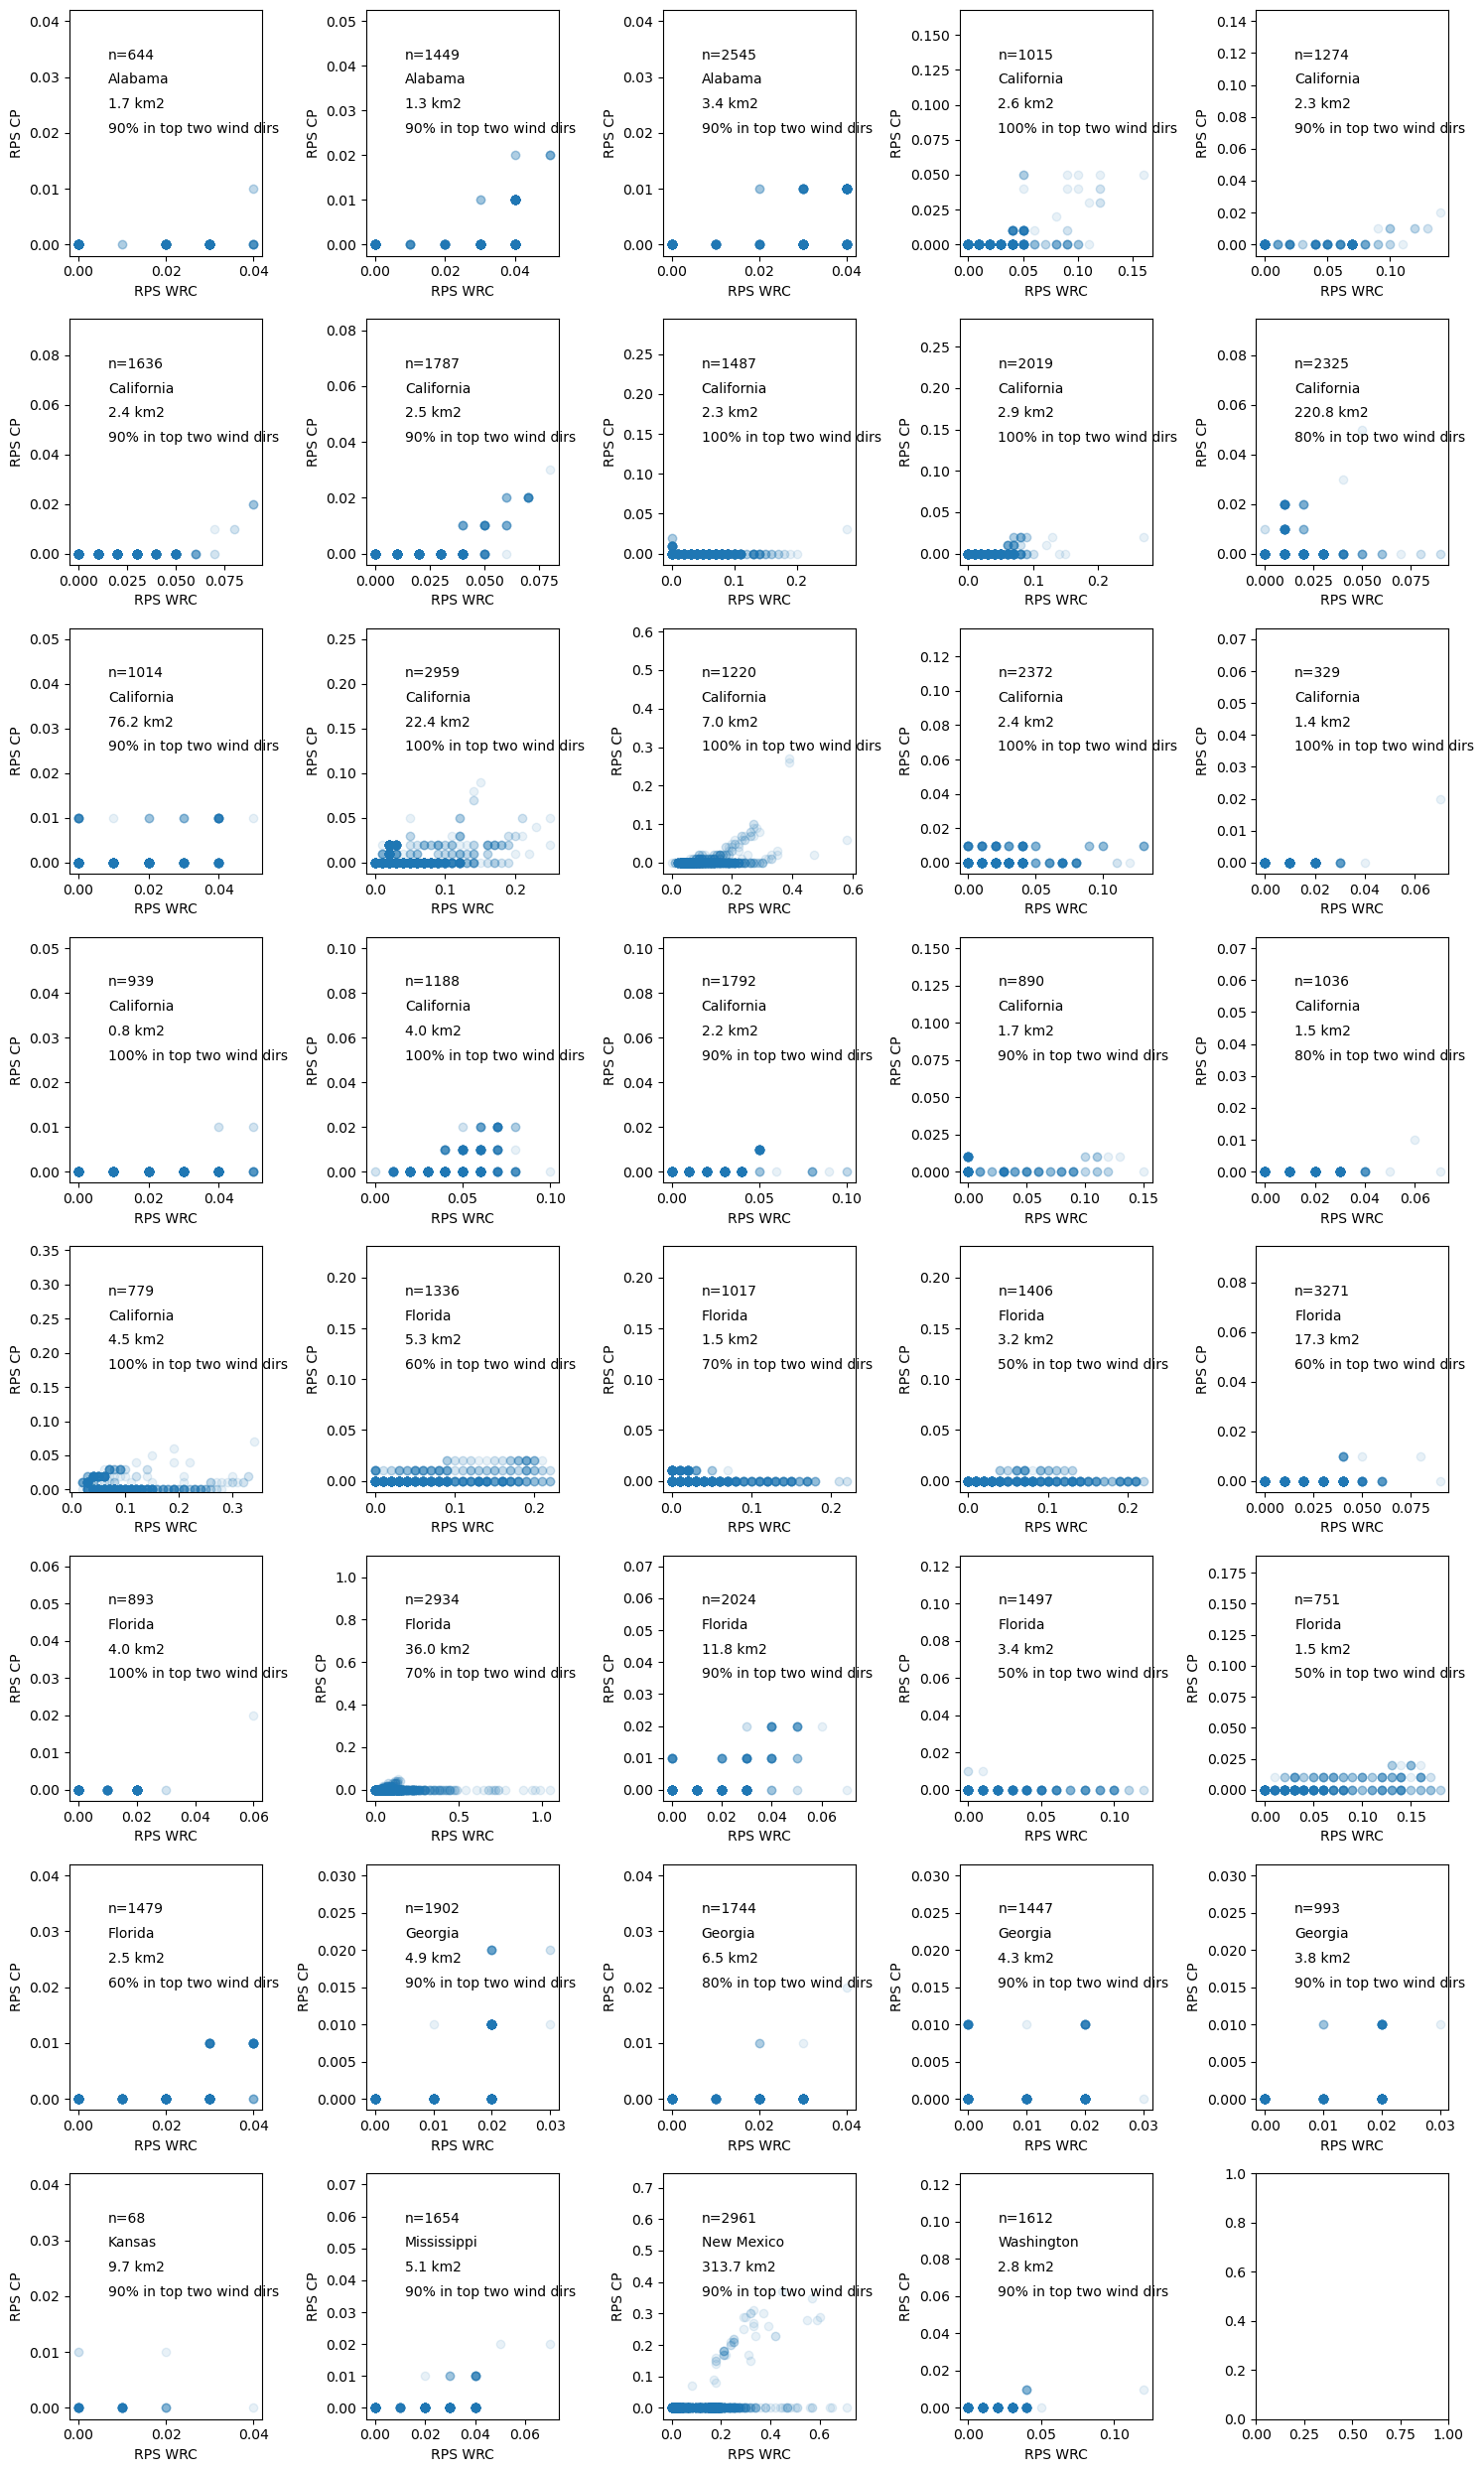

In [134]:
%%time
scatter_plot_buildings_hotspot_tracts(
    hotspot_geoids, buildings_in_census_tracts, census_tracts, wind_ds, states
)

## Is there a relationship between high-/low-hotspots and the consistency of wind direction?

In [ ]:
hotspot_geoids = hotspots['GEOID'].values

In [140]:
from functools import lru_cache

import pyproj


@lru_cache
def _make_transformers(wkt):
    crs_proj = pyproj.CRS.from_wkt(wkt)
    crs_geo = pyproj.CRS.from_epsg(4326)
    fwd = pyproj.Transformer.from_crs(crs_geo, crs_proj, always_xy=True)
    inv = pyproj.Transformer.from_crs(crs_proj, crs_geo, always_xy=True)
    return fwd, inv


def select_point(ds, lon, lat, method='nearest'):
    fwd, inv = _make_transformers(ds.crs.attrs['crs_wkt'])
    x_pt, y_pt = fwd.transform(lon, lat)
    out = ds.sel(x=x_pt, y=y_pt, method=method)
    return out

In [148]:
# plot the sum of top two direction densities across CONUS
wind_distrib = catalog.get_dataset('conus404-ffwi-p99-wind-direction-distribution').to_xarray()

In [149]:
import numpy as np
import xarray as xr


def sum_top2(arr):
    # Sort along the last axis (wind_direction), get the last two (largest) and sum
    arr_sorted = np.sort(arr, axis=-1)
    return arr_sorted[..., -2:].sum(axis=-1)


top2_sum = xr.apply_ufunc(
    sum_top2,
    wind_distrib,
    input_core_dims=[['wind_direction']],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
).compute()

In [150]:
from ocr.conus404 import geo_sel, load_conus404

In [151]:
tract_performance_stats = tract_performance_stats.reset_index()

ValueError: cannot insert level_0, already exists

In [153]:
conus404 = load_conus404(add_spatial_constants=True)
src_crs_wkt = conus404['crs'].attrs['crs_wkt']
top2_sum.crs.attrs['crs_wkt'] = src_crs_wkt

In [156]:
tract_performance_stats = tract_performance_stats.to_crs('epsg:5070')

In [154]:
%%time
for i, row in tract_performance_stats.iterrows():
    tract_lat = row.geometry.centroid.y
    tract_lon = row.geometry.centroid.x
    wind_consistency = geo_sel(top2_sum, tract_lon, tract_lat).wind_direction_distribution.values
    tract_performance_stats.at[i, 'wind_consistency'] = wind_consistency

CPU times: user 8.77 s, sys: 0 ns, total: 8.77 s
Wall time: 8.77 s


In [161]:
tract_size_threshold = 16e6  # 4km2 (~size of CONUS404 pixel)

In [164]:
smaller_tracts = tract_performance_stats[tract_performance_stats.area < tract_size_threshold]

In [171]:
bigger_tracts = tract_performance_stats[tract_performance_stats.area > tract_size_threshold]

In [208]:
fig, axarr = plt.subplots()
tracts_high = find_hotspots(0.9, tract_performance_stats, 'high')
axarr.hist(tract_performance_stats['wind_consistency'].values, alpha=0.5, label='all')
axarr.hist(tracts_high['wind_consistency'].values, alpha=0.5, label='high hot spots')

plt.legend()

In [197]:
smaller_low = find_hotspots(0.2, smaller_tracts, 'low')
len(smaller_low)

718

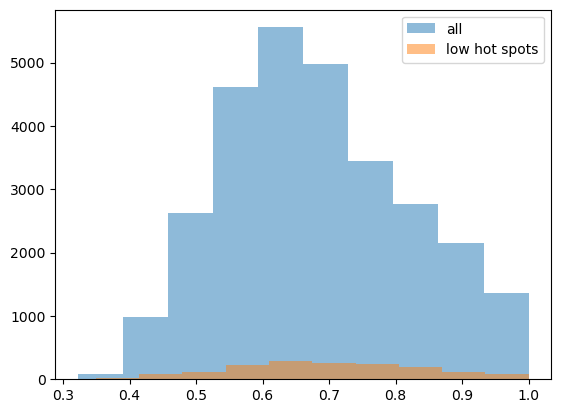

In [206]:
fig, axarr = plt.subplots()
tracts_low = find_hotspots(0.2, tract_performance_stats, 'low')
axarr.hist(tract_performance_stats['wind_consistency'].values, alpha=0.5, label='all')
axarr.hist(tracts_low['wind_consistency'].values, alpha=0.5, label='low hot spots')

plt.legend()

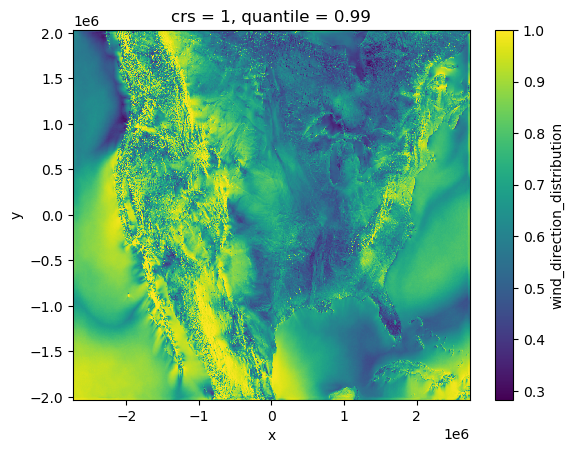

In [137]:
top2_sum.wind_direction_distribution.plot()

In [ ]:
# histogram of biases across entire domain

<Axes: ylabel='Frequency'>

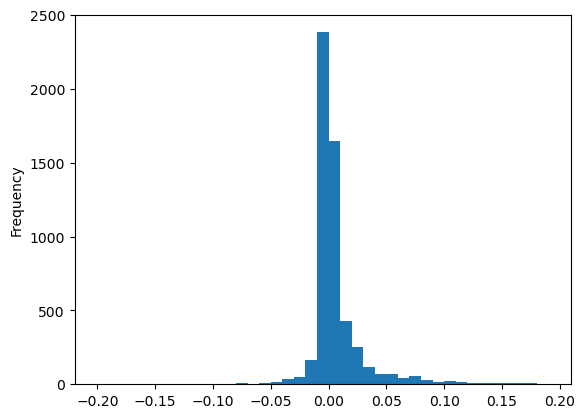

In [204]:
tract_performance_stats['bias'].plot(kind='hist', bins=np.arange(-0.2, 0.2, 0.01))

In [ ]:
# for sample census tracts (LA fires, Paradise, ...?) histograms of risk